In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import RidgeCV, LassoCV

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# !! Diclaimer !!: Mon premier essais était volontairement laissé à l'abandon, 
#Le sujet mérite d'être étudié en profondeur et j'en avais envie. Toutefois je vais rester au plus proche de l'excercice demandé
#même si j'aurai aimé voir le résultat avec Elastic Net

In [3]:
hp = pd.read_csv('house_price.csv')
hp.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#check des proportions valeurs manquantes

def percent_missing(df):
    missing_count = df.isnull().sum().sort_values(ascending = False)
    missing_percent = round(100 * df.isnull().sum().sort_values(ascending = False) / len(df),2)
    missing_count = pd.DataFrame(missing_count[missing_count > 0], columns= ['missing_count'])
    missing_percent = pd.DataFrame(missing_percent[missing_percent > 0], columns=['missing_percent'])
    missing_table = pd.concat([missing_count,missing_percent], axis = 1)
    
    return missing_table

In [5]:
percent_missing(hp).head()

,missing_count,missing_percent
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26


In [6]:
#delete id columns and if % > 50
hp = hp.drop(['Id','PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1)

In [7]:
#hp.loc[hp['col'].isnull(),:]

In [8]:
# Trie des features et fill des NaN
cat_vars = hp.select_dtypes(include = 'object')
num_vars = hp.select_dtypes(exclude = 'object')

cat_vars = cat_vars.apply(lambda x: x.fillna(x.mode()[0]))
num_vars = num_vars.apply(lambda x: x.fillna(x.mean()))

print(cat_vars.isnull().sum())
print(num_vars.isnull().sum())

MSZoning         0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
Functional       0
FireplaceQu      0
GarageType       0
GarageFinish     0
GarageQual       0
GarageCond       0
PavedDrive       0
SaleType         0
SaleCondition    0
dtype: int64
MSSubClass       0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0

In [9]:
#Preprocessing des variables numériques

scaler = preprocessing.StandardScaler()
num_vars_scaled = scaler.fit_transform(num_vars)
num_vars_scaled = pd.DataFrame(num_vars_scaled, columns=num_vars.columns, index=num_vars.index)

In [14]:
# Création des features dummies
cat_dummies= pd.get_dummies(cat_vars) # pas de drop first/last en regression 

In [15]:
#df final
df = pd.concat([num_vars_scaled, cat_dummies], axis = 1)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 276 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(37), uint8(239)
memory usage: 762.9 KB


In [17]:
#Une heatmap serait illisible... seule les corrélations de la target nous intéresses
hp.corr()['SalePrice'].sort_values(ascending=False).head()

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64

In [18]:
# data et target
feats = df.drop("SalePrice", axis = 1)
target = df["SalePrice"]

In [19]:
#Split des données
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.2)

In [249]:
# fonction neg rmse

def rmse_cv(estimator, X, y):
    return cross_val_score(estimator, X, y, cv=5, scoring='neg_mean_squared_error').mean()
#return cross_val_score(estimator, X, y, cv=5, scoring=make_scorer(mean_squared_error)).mean()       

In [298]:
#Listes des alphas
alphas = [0.01, 0.05, 0.1, 0.3, 0.8, 1, 5, 10, 15, 30, 50]

In [301]:
rmse= []
for i in alphas:
    ridge = RidgeCV(alphas= i).fit(X_train, y_train)
    rmse.append(rmse_cv(ridge, X_train, y_train))
    print(i,rmse_cv(ridge, X_train, y_train))
    
coeff= pd.DataFrame(rmse, alphas, columns=['RMSE']).reset_index()
coeff= coeff.rename(columns={'index':'alphas'})
coeff = coeff.sort_values(by='RMSE', ascending=False)
coeff

0.01 -0.18351313021128182
0.05 -0.18135916291833623
0.1 -0.18031518791806053
0.3 -0.18088763960878124
0.8 -0.18358086836216786
1 -0.18407035177865053
5 -0.18358605514376242
10 -0.1822091608091912
15 -0.1814290142987492
30 -0.18036268690889504
50 -0.17987236934203776


,alphas,RMSE
10,50.00,-0.179872
2,0.10,-0.180315
9,30.00,-0.180363
3,0.30,-0.180888
1,0.05,-0.181359
8,15.00,-0.181429
7,10.00,-0.182209
0,0.01,-0.183513
4,0.80,-0.183581
6,5.00,-0.183586


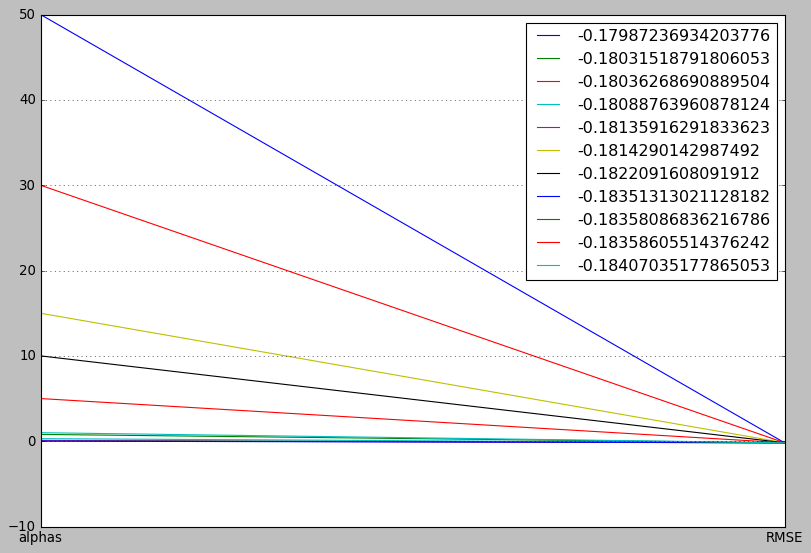

In [300]:
plt.style.use('classic')
plt.figure(figsize=(12,8))

for i in range(len(coeff)):
    plt.plot([k for k in coeff.columns],[coeff[j].iloc[i] for j in coeff.columns])
    
plt.legend(coeff['RMSE'],loc="upper right")
plt.grid();

In [288]:
#Ridge régularisée
ridge_reg = RidgeCV(alphas=50).fit(X_train, y_train)
print('Score R² :', ridge_reg.score(X_test, y_test))
print('RMSE neg :', rmse_cv(ridge_reg, X_test, y_test))

Score R² : 0.796619784161408
RMSE neg : -0.34048190236217446


In [303]:
# Déterminer les alphas opti

lasso_reg = LassoCV(alphas=[10, 1, 0.1, 0.001, 0.0005], cv=50).fit(X_train, y_train)
print('alpha selectionné:', lasso_reg.alpha_)

alpha selectionné: 0.001


In [304]:
# performance du modèle
print('Score R² :', lasso_reg.score(X_test, y_test))
print('RMSE neg :', rmse_cv(lasso_reg, X_test, y_test))

Score R² : 0.8267899981435632
RMSE neg : -0.3955639845566157


In [375]:
# Nombre de variables prises en compte
lasso_coef = lasso_reg.coef_

print('Nombre de variables GARDEES par le modèle:', lasso_coef[lasso_coef > 0].shape[0])
print('Nombre de variables ELIMINEES par le modèle:', lasso_coef[lasso_coef < 0].shape[0])

Nombre de variables GARDEES par le modèle: 71
Nombre de variables ELIMINEES par le modèle: 49


In [348]:
# feature importantes
features_importance = pd.DataFrame(lasso_coef, columns=['feats'], 
                                   index=feats.columns).sort_values(by='feats', ascending= True)
features_importance = features_importance.loc[features_importance['feats'] > 0.2] 

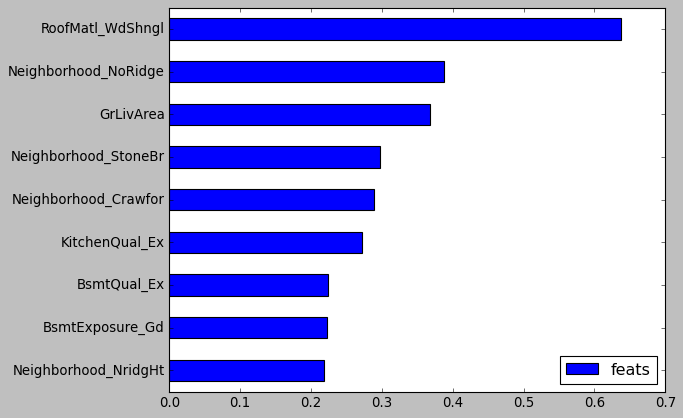

In [379]:
features_importance.plot.barh();

In [372]:
ridge_coef = ridge_reg.coef_
features_im = pd.DataFrame(ridge_coef, columns=['feats'], 
                                   index=feats.columns).sort_values(by='feats', ascending= True)
features_im = features_im.loc[features_im['feats']>0.10] 

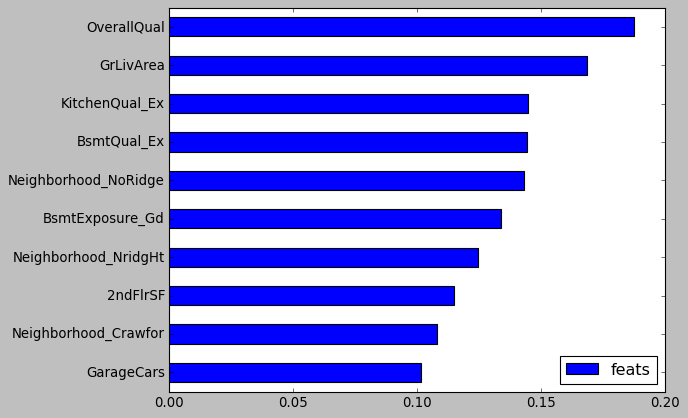

In [378]:
features_im.plot.barh();

In [ ]:
#new_inverse = scaler.inverse_transform(y_new)

In [ ]:
#Import the function
from sklearn.preprocessing import StandardScaler

#Say we have a train dataset called Data_train
Scaler = StandardScaler.fit(Data_train)
Data_train_scaled = Scaler.transform(Data_train)

#And we want to apply this transformation to a new dataset called New_data
New_data_scaled = Scaler.transform(New_data)